### Obter o Dataset via LibCurl

In [ ]:
# utilizando a libcurl para pegar o dataset
!curl -L -o /content/optimization-of-machine-downtime.zip \
  https://www.kaggle.com/api/v1/datasets/download/srinivasanusuri/optimization-of-machine-downtime
!unzip /content/optimization-of-machine-downtime.zip
!mv /content/optimization-of-machine-downtime /content/'Machine Downtime.csv'
!rm /content/optimization-of-machine-downtime.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  100k  100  100k    0     0   124k      0 --:--:-- --:--:-- --:--:--  559k
Archive:  /content/optimization-of-machine-downtime.zip
  inflating: Machine Downtime.csv    
mv: cannot stat '/content/optimization-of-machine-downtime': No such file or directory


## Funções prontas

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
import time
import datetime

In [ ]:
def calcular_media(valores):
    return sum(valores) / len(valores)


def calcular_media_ponderada(valores, pesos):
    return sum(v * p for v, p in zip(valores, pesos)) / sum(pesos)


def calcular_media_truncada(valores, proporcao_remover):
    valores_ordenados = sorted(valores)
    n_remover = int(len(valores) * proporcao_remover)
    valores_truncados = valores_ordenados[n_remover:len(valores) - n_remover]
    return sum(valores_truncados) / len(valores_truncados)


def calcular_mediana(valores):
    valores_ordenados = sorted(valores)
    n = len(valores)
    meio = n // 2
    if n % 2 == 0:
        return (valores_ordenados[meio - 1] + valores_ordenados[meio]) / 2
    else:
        return valores_ordenados[meio]

def encontrar_outliers(valores, ajuste): #ajuste 1.1, 1.2
    # Ordenar os valores
    valores_ordenados = sorted(valores)

    # Encontrar Q1 (25º percentil) e Q3 (75º percentil)
    q1 = calcular_mediana(valores_ordenados[:len(valores_ordenados) // 2])
    q3 = calcular_mediana(valores_ordenados[len(valores_ordenados) // 2:])

    # Calcular IQR (Intervalo entre Quartis)
    iqr = q3 - q1

    # Definir limites para outliers
    limite_inferior = q1 - ajuste * iqr
    limite_superior = q3 + ajuste * iqr

    # Encontrar os outliers
    outliers = [v for v in valores if v < limite_inferior or v > limite_superior]
    outliers = [v for v in outliers if v != -1] # remover os outliers criados por nós
    return outliers



# Função para calcular a variância
def calcular_variancia(dados, media):
    return sum((x - media) ** 2 for x in dados) / len(dados)

# Função para calcular o desvio padrão
def calcular_desvio_padrao(variancia):
    return variancia ** 0.5

# Função para calcular a correlação de Pearson
def calcular_correlacao(x, y):
    # Calcular a média de x e y
    media_x = calcular_media(x)
    media_y = calcular_media(y)

    # Calcular a variância de x e y
    variancia_x = calcular_variancia(x, media_x)
    variancia_y = calcular_variancia(y, media_y)

    # Calcular o desvio padrão de x e y
    desvio_x = calcular_desvio_padrao(variancia_x)
    desvio_y = calcular_desvio_padrao(variancia_y)

    # Calcular a covariância
    covariancia = sum((x[i] - media_x) * (y[i] - media_y) for i in range(len(x))) / len(x)

    # Calcular a correlação de Pearson
    return covariancia / (desvio_x * desvio_y)

# Calculando a matriz de correlação entre todos os pares de atributos
def calcular_matriz_correlacao(df):
  atributos = df.columns
  matriz_correlacao = pd.DataFrame(index=atributos, columns=atributos)
  for i in range(len(atributos)):
      for j in range(i, len(atributos)):
          atributo_x = atributos[i]
          atributo_y = atributos[j]

          # Calculando a correlação entre os atributos
          correlacao = calcular_correlacao(df[atributo_x], df[atributo_y])

          # Preenchendo a matriz de correlação
          matriz_correlacao.loc[atributo_x, atributo_y] = correlacao
          matriz_correlacao.loc[atributo_y, atributo_x] = correlacao  # Matriz é simétrica

  # retorna a matriz de correlação
  return matriz_correlacao

def plot_matriz_correlacao(matriz_correlacao):
  # Visualizando a matriz de correlação com um heatmap
  plt.figure(figsize=(15, 8))
  sns.heatmap(matriz_correlacao.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.title('Matriz de Correlação')
  plt.show()

def plt_matriz_disperscao(df):
  # Gráfico de dispersão (scatter plot) entre todas as combinações de atributos
  atributos = df.columns

  # Criando a matriz de gráficos de dispersão usando pairplot do Seaborn
  sns.pairplot(df)
  plt.suptitle('Gráficos de Dispersão entre Atributos', y=1.02)  # Título para o gráfico
  plt.show()

def plt_hist(dados, bins=5):
    # Criando o histograma
    plt.hist(dados, bins, edgecolor='black')  # bins define o número de intervalos

    # Adicionando título e rótulos dos eixos
    plt.title('Histograma de Dados Exemplo')
    plt.xlabel('Valores')
    plt.ylabel('Frequência')

    # Exibindo o histograma
    plt.show()

## Funções desenvolvidas

In [ ]:
def convert_Machine_ID(df):
  for i in df.index:
    if df.at[i, 'Machine_ID'] == 'Makino-L1-Unit1-2013':
      df.at[i, 'Machine_ID'] = 0
    elif df.at[i, 'Machine_ID'] == 'Makino-L2-Unit1-2015':
      df.at[i, 'Machine_ID'] = 1
    elif df.at[i, 'Machine_ID'] == 'Makino-L3-Unit1-2015':
      df.at[i, 'Machine_ID'] = 2
  return df

def convert_time(df):
  tempos = []
  for data in df:
    tempos.append(time.mktime(datetime.datetime.strptime(data,"%d-%m-%Y").timetuple()))
  return tempos

def convert_assembly_line_n(df):
  for i in df.index:
    if df.at[i, 'Assembly_Line_No'] == 'Shopfloor-L1':
      df.at[i, 'Assembly_Line_No'] = 0
    elif df.at[i, 'Assembly_Line_No'] == 'Shopfloor-L2':
      df.at[i, 'Assembly_Line_No'] = 1
    elif df.at[i, 'Assembly_Line_No'] == 'Shopfloor-L3':
      df.at[i, 'Assembly_Line_No'] = 2
  return df

def convert_downtime(df):
  for i in df.index:
    if df.at[i, 'Downtime'] == 'Machine_Failure':
      df.at[i, 'Downtime'] = 1
    elif df.at[i, 'Downtime'] == 'No_Machine_Failure':
      df.at[i, 'Downtime'] = 0
  return df

def calcular_desvios(valores, media):
    return [x - media for x in valores]

def calcular_percentil(valores, percentil):
    valores_ordenados = sorted(valores)
    indice = int((percentil / 100) * len(valores_ordenados))
    return valores_ordenados[max(0, min(indice, len(valores_ordenados) - 1))]


## Carregamento do dataset

In [ ]:
df = pd.read_csv('Machine Downtime.csv')
df.convert_dtypes(infer_objects=True, convert_string=True, convert_integer=True, convert_boolean=True, convert_floating=True, dtype_backend='numpy_nullable')

df['Date'] = convert_time(df['Date'])
# df = convert_Machine_ID(df)
df = convert_assembly_line_n(df)

df.fillna(-1, inplace=True)
df = df.drop(columns=['Machine_ID'])
df

,Date,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
0,1.640909e+09,0,71.040000,6.933725,6.284965,25.6,46.0,33.4,1.291,26.492,25892.0,335.0,24.055326,3.58,Machine_Failure
1,1.640909e+09,0,125.330000,4.936892,6.196733,35.3,47.4,34.6,1.382,25.274,19856.0,368.0,14.202890,2.68,Machine_Failure
2,1.640909e+09,2,71.120000,6.839413,6.655448,13.1,40.7,33.0,1.319,30.608,19851.0,325.0,24.049267,3.55,Machine_Failure
3,1.653955e+09,1,139.340000,4.574382,6.560394,24.4,44.2,40.6,0.618,30.791,18461.0,360.0,25.860029,3.55,Machine_Failure
4,1.648685e+09,0,60.510000,6.893182,6.141238,4.1,47.3,31.4,0.983,25.516,26526.0,354.0,25.515874,3.55,Machine_Failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1.643674e+09,0,112.715506,5.220885,6.196610,22.3,48.8,37.2,0.910,20.282,20974.0,282.0,22.761610,2.72,No_Machine_Failure
2496,1.643674e+09,0,103.086653,5.211886,7.074653,11.9,48.3,31.5,1.106,34.708,20951.0,319.0,22.786597,2.94,No_Machine_Failure
2497,1.643674e+09,1,118.643165,5.212991,6.530049,4.5,49.9,36.2,0.288,16.828,20958.0,335.0,22.778987,-1.00,No_Machine_Failure
2498,1.643674e+09,2,145.855859,5.207777,6.402655,12.2,44.5,32.1,0.995,26.498,20935.0,376.0,22.804012,2.79,No_Machine_Failure


### Cálculos de estimativas de localização

In [ ]:
colunas_numericas = [y for y in df.select_dtypes(include=['float64','int64'] ).columns if y not in ['Date','Machine_ID', 'Assembly_Line_No']]
for coluna in colunas_numericas:
  pesos = df[coluna].value_counts()
  print(f"Estimativas de localidade para a coluna: {coluna}")
  print(f'''
A moda da coluna {coluna} é: {[x for x in df[coluna].mode()]}
A média da coluna {coluna} é: {calcular_media(df[coluna])}
A média ponderada da coluna {coluna} é: {calcular_media_ponderada(df[coluna], pesos.values)}
A média truncada da coluna {coluna} é: {calcular_media_truncada(df[coluna], 0.2)}
A mediana da coluna {coluna} é: {calcular_mediana(df[coluna])}
Os outliers da coluna {coluna} são: {encontrar_outliers(df[coluna], 1.1)}''',end='\n\n\n')


Estimativas de localidade para a coluna: Hydraulic_Pressure(bar)

A moda da coluna Hydraulic_Pressure(bar) é: [88.27913423, 89.4587468, 90.4587468]
A média da coluna Hydraulic_Pressure(bar) é: 100.9994474424439
A média ponderada da coluna Hydraulic_Pressure(bar) é: 101.7826276684038
A média truncada da coluna Hydraulic_Pressure(bar) é: 99.87668780811339
A mediana da coluna Hydraulic_Pressure(bar) é: 96.50807729
Os outliers da coluna Hydraulic_Pressure(bar) são: [15.32576081, 191.0, -14.32645418]


Estimativas de localidade para a coluna: Coolant_Pressure(bar)

A moda da coluna Coolant_Pressure(bar) é: [4.566853902, 4.84252053, 5.567856573, 5.918357337, 6.560332199, 6.839413159, 6.863944117, 6.893181921]
A média da coluna Coolant_Pressure(bar) é: 4.901860829119195
A média ponderada da coluna Coolant_Pressure(bar) é: 5.11423242827278
A média truncada da coluna Coolant_Pressure(bar) é: 4.953817123738682
A mediana da coluna Coolant_Pressure(bar) é: 4.925774489
Os outliers da coluna Coolant

### Cálculos de estimativas de variabilidade

In [ ]:
# Calculo dos desvios, desvio padrão e variância (estimativas de variabilidade)

for coluna_numerica in colunas_numericas:
  print(f"Coluna: '{coluna_numerica}'")
  media = calcular_media(df[coluna_numerica])
  print("Média:", media)

  desvios = calcular_desvios(df[coluna_numerica], media)
  variancia = calcular_variancia(df[coluna_numerica], media)
  desvio_padrao = calcular_desvio_padrao(variancia)
  percentil = calcular_percentil(df[coluna_numerica], 75)

  print("Desvios:", desvios)
  print("Variância:", str(round(variancia,2)))
  print("Desvio Padrão:", str(round(desvio_padrao,2)))
  print("Percentil:", str(round(percentil, 2)), end='\n\n\n')

Coluna: 'Hydraulic_Pressure(bar)'
Média: 100.9994474424439
Desvios: [-29.95944744244389, 24.330552557556103, -29.87944744244389, 38.34055255755611, -40.4894474424439, 36.37055255755611, 34.93055255755611, 26.715716057556108, 22.6190085575561, 33.020552557556115, -29.2894474424439, 33.5405525575561, -45.469447442443894, -39.2694474424439, -20.7294474424439, 41.36055255755612, -37.2394474424439, 40.14055255755609, -7.349447442443889, -26.139447442443895, -20.65944744244389, 38.67175965755611, -9.499447442443895, 47.66310055755609, 30.048744357556117, 44.299580457556104, -2.299447442443892, 69.0900136575561, -38.65944744244389, 10.75075785755611, 26.56954435755611, 10.286629157556106, 23.914315857556105, 24.950552557556108, -28.6194474424439, -22.669447442443897, 27.898214057556103, -4.039447442443901, 44.980552557556095, -49.8394474424439, 19.60627375755611, -15.179447442443902, -42.39944744244389, 26.459911657556106, 2.5766991575561065, -43.6994474424439, 6.931523257556108, 15.075063357

### Distribuição de dados

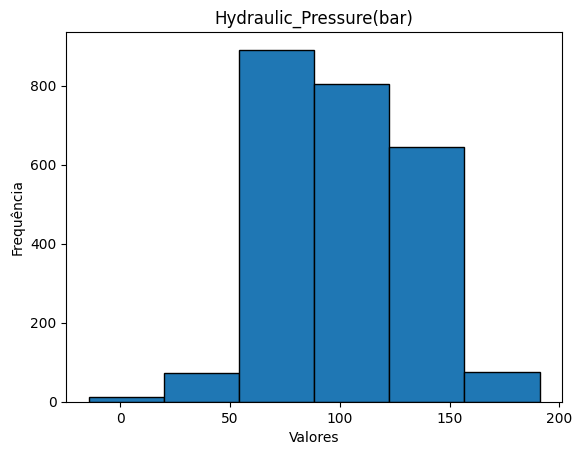

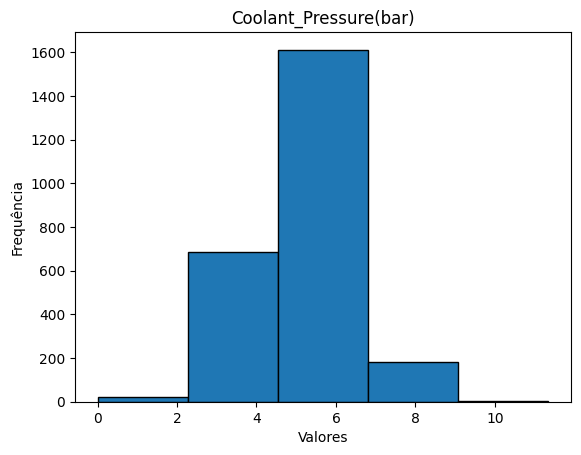

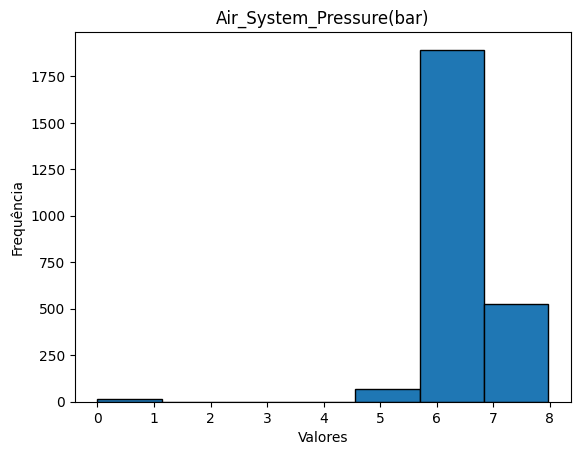

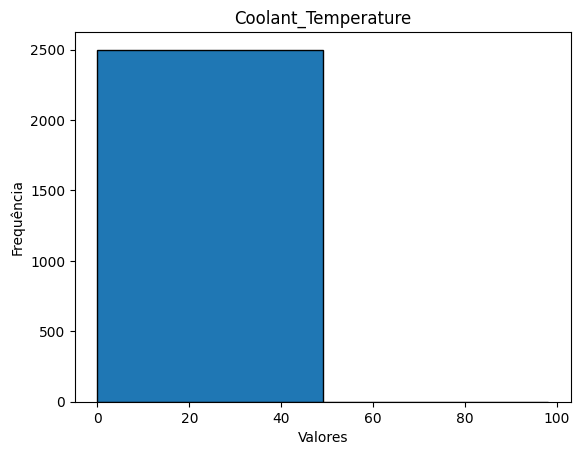

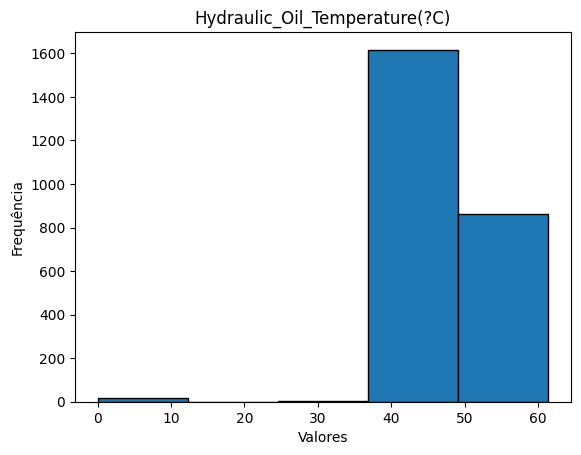

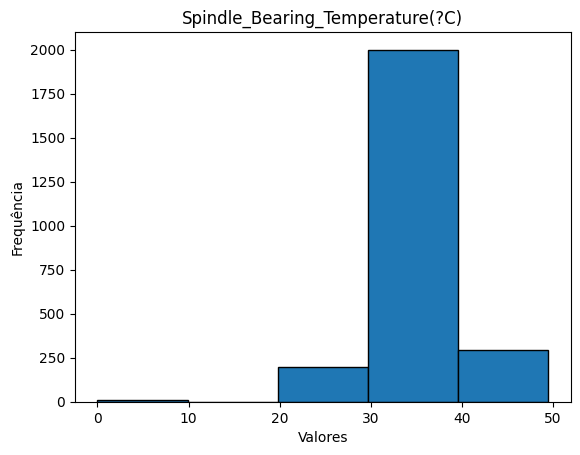

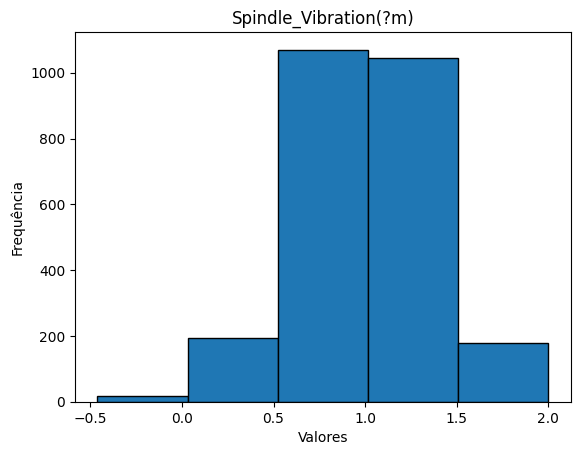

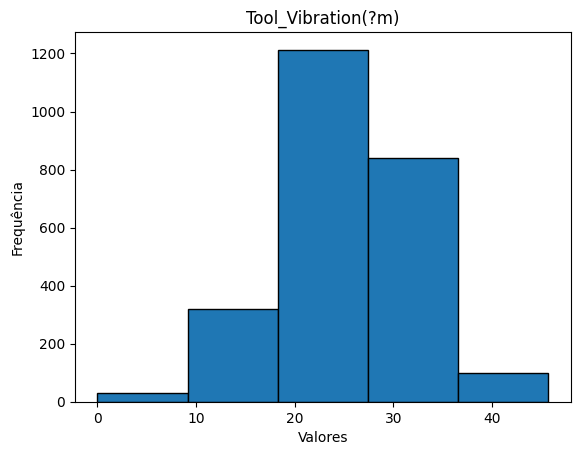

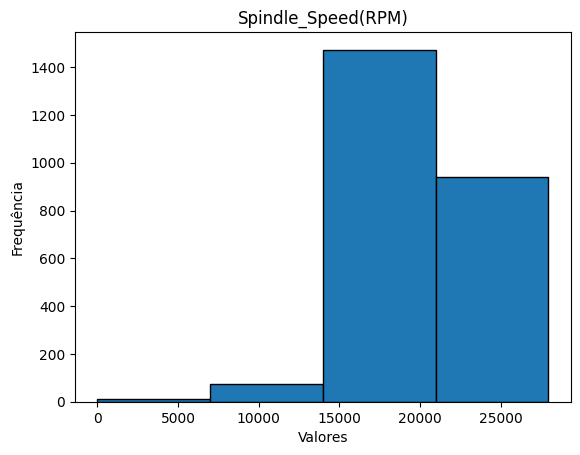

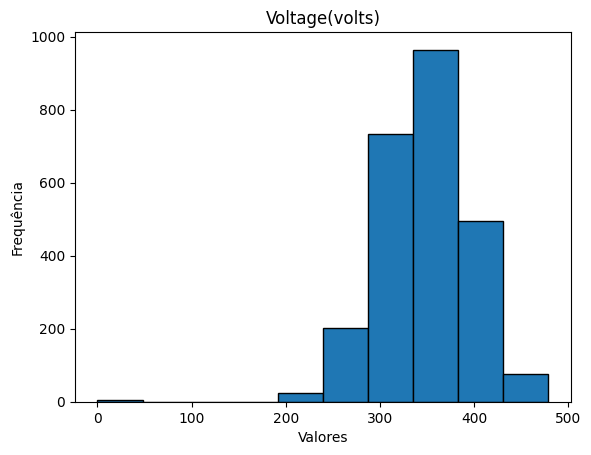

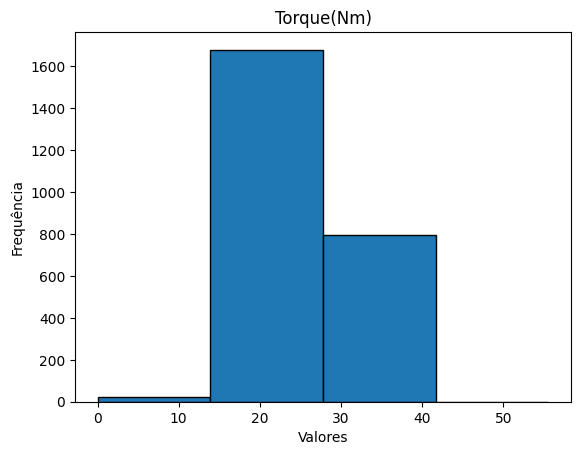

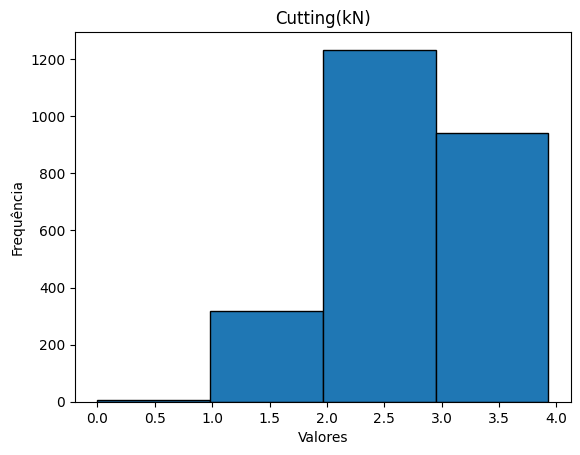

In [ ]:
def plt_hist(dados, titulo:str, bins=8):
    # Criando o histograma
    plt.hist(dados, bins, edgecolor='black')  # bins define o número de intervalos

    # Adicionando título e rótulos dos eixos
    plt.title(titulo)
    plt.xlabel('Valores')
    plt.ylabel('Frequência')

    # Exibindo o histograma
    plt.show()
    print('',end='\n\n\n\n')


#Criando Histogramas
qtde_bins = {
    'Hydraulic_Pressure(bar)': 6,
    'Coolant_Pressure(bar)': 5,
    'Air_System_Pressure(bar)': 7,
    'Coolant_Temperature': 2,
    'Hydraulic_Oil_Temperature(?C)': 5,
    'Spindle_Bearing_Temperature(?C)': 5,
    'Spindle_Vibration(?m)': 5,
    'Tool_Vibration(?m)': 5,
    'Spindle_Speed(RPM)': 4,
    'Voltage(volts)': 10,
    'Torque(Nm)': 4,
    'Cutting(kN)': 4
}
for coluna in colunas_numericas:
  plt_hist(df[coluna], coluna, bins=qtde_bins[coluna])

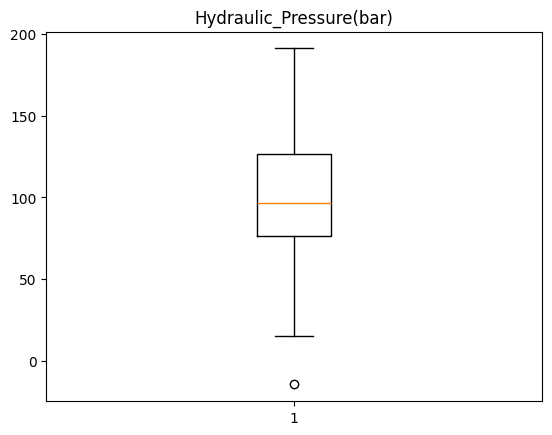

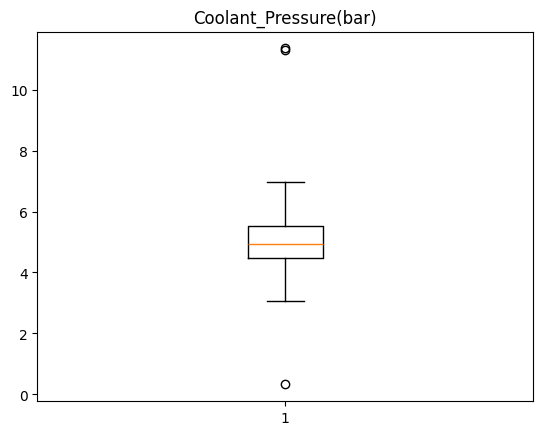

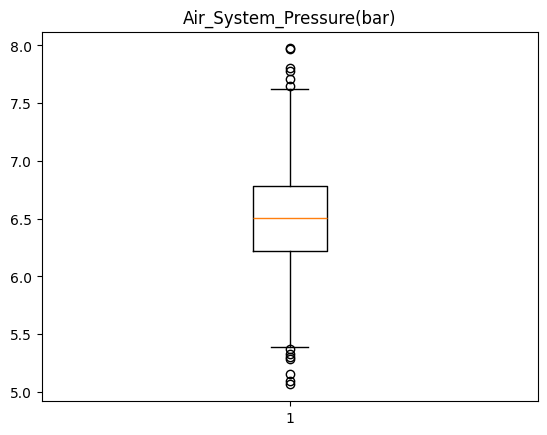

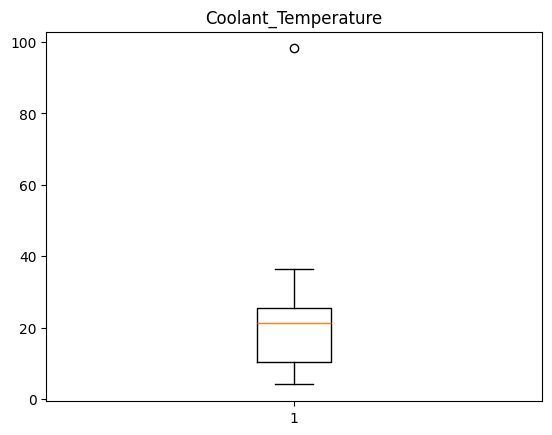

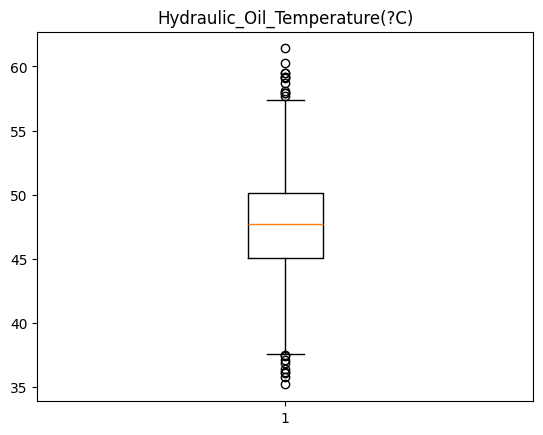

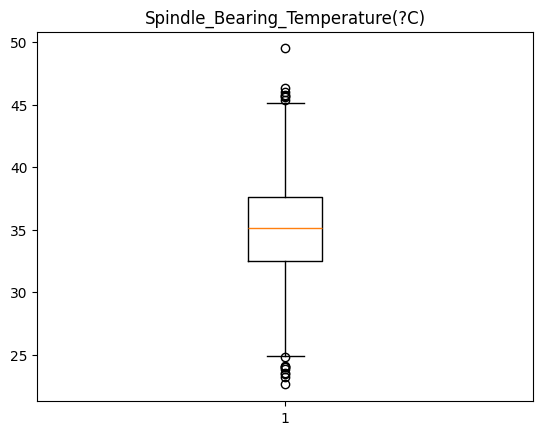

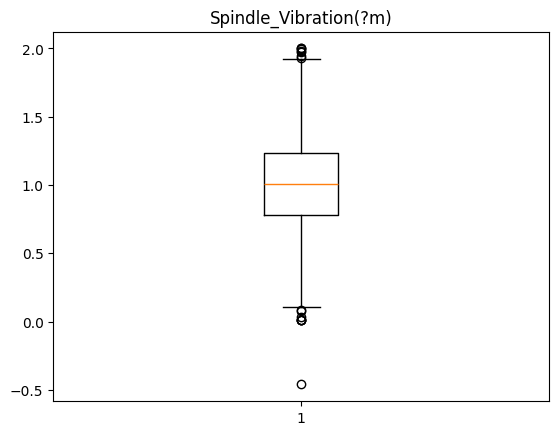

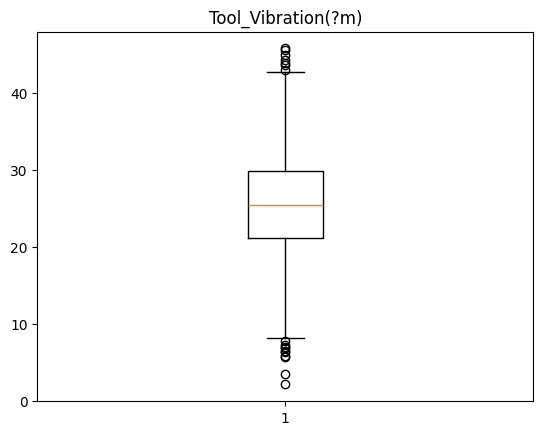

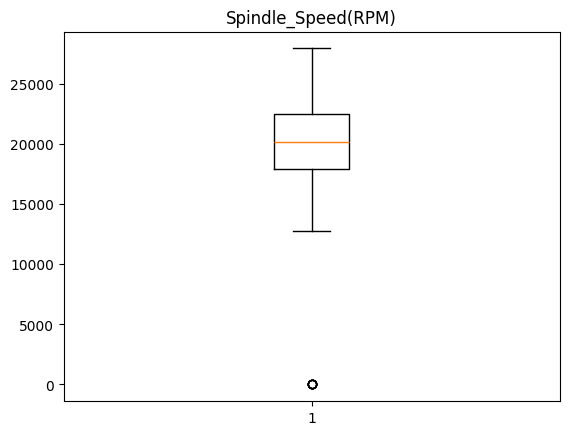

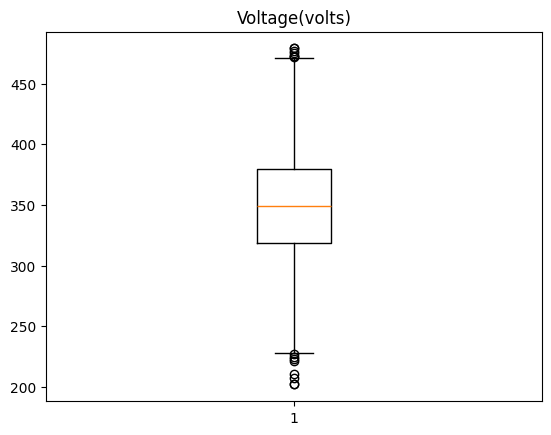

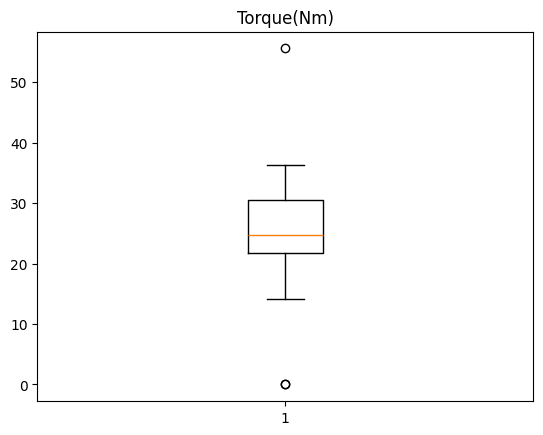

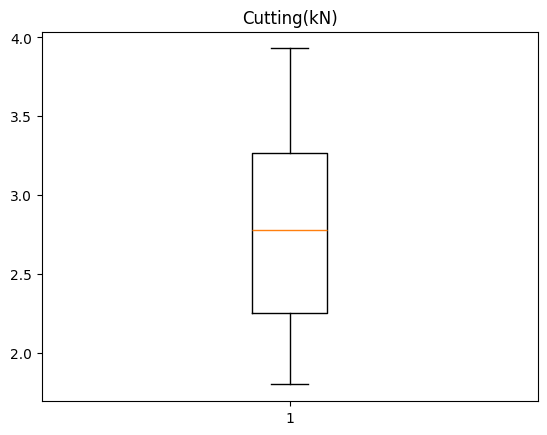

In [ ]:
# Criando os boxplots

def plt_boxplot(dados, titulo:str):

    dados_filtrados = [x for x in dados if x != -1]
    # Criando o boxplot
    plt.boxplot(dados_filtrados)

    # Adicionando título
    plt.title(titulo)

    # Exibindo o boxplot
    plt.show()
    print('', end='\n\n\n\n')

for coluna in colunas_numericas:
  plt_boxplot(df[coluna], coluna)

### Correlações

In [ ]:
# Fiz uma cópia do meu data frame pois para a matriz de correlação eu tive que
# converter o atributo Machine Downtime para o categórico binário, porém mais a
# frente eu precisaria deste atributo na sua forma normal
df_p_correlacao = df.copy()
df_p_correlacao = convert_downtime(df_p_correlacao)
matriz = calcular_matriz_correlacao(df_p_correlacao)
# matriz
df_p_correlacao

,Date,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
0,1.640909e+09,0,71.040000,6.933725,6.284965,25.6,46.0,33.4,1.291,26.492,25892.0,335.0,24.055326,3.58,1
1,1.640909e+09,0,125.330000,4.936892,6.196733,35.3,47.4,34.6,1.382,25.274,19856.0,368.0,14.202890,2.68,1
2,1.640909e+09,2,71.120000,6.839413,6.655448,13.1,40.7,33.0,1.319,30.608,19851.0,325.0,24.049267,3.55,1
3,1.653955e+09,1,139.340000,4.574382,6.560394,24.4,44.2,40.6,0.618,30.791,18461.0,360.0,25.860029,3.55,1
4,1.648685e+09,0,60.510000,6.893182,6.141238,4.1,47.3,31.4,0.983,25.516,26526.0,354.0,25.515874,3.55,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1.643674e+09,0,112.715506,5.220885,6.196610,22.3,48.8,37.2,0.910,20.282,20974.0,282.0,22.761610,2.72,0
2496,1.643674e+09,0,103.086653,5.211886,7.074653,11.9,48.3,31.5,1.106,34.708,20951.0,319.0,22.786597,2.94,0
2497,1.643674e+09,1,118.643165,5.212991,6.530049,4.5,49.9,36.2,0.288,16.828,20958.0,335.0,22.778987,-1.00,0
2498,1.643674e+09,2,145.855859,5.207777,6.402655,12.2,44.5,32.1,0.995,26.498,20935.0,376.0,22.804012,2.79,0


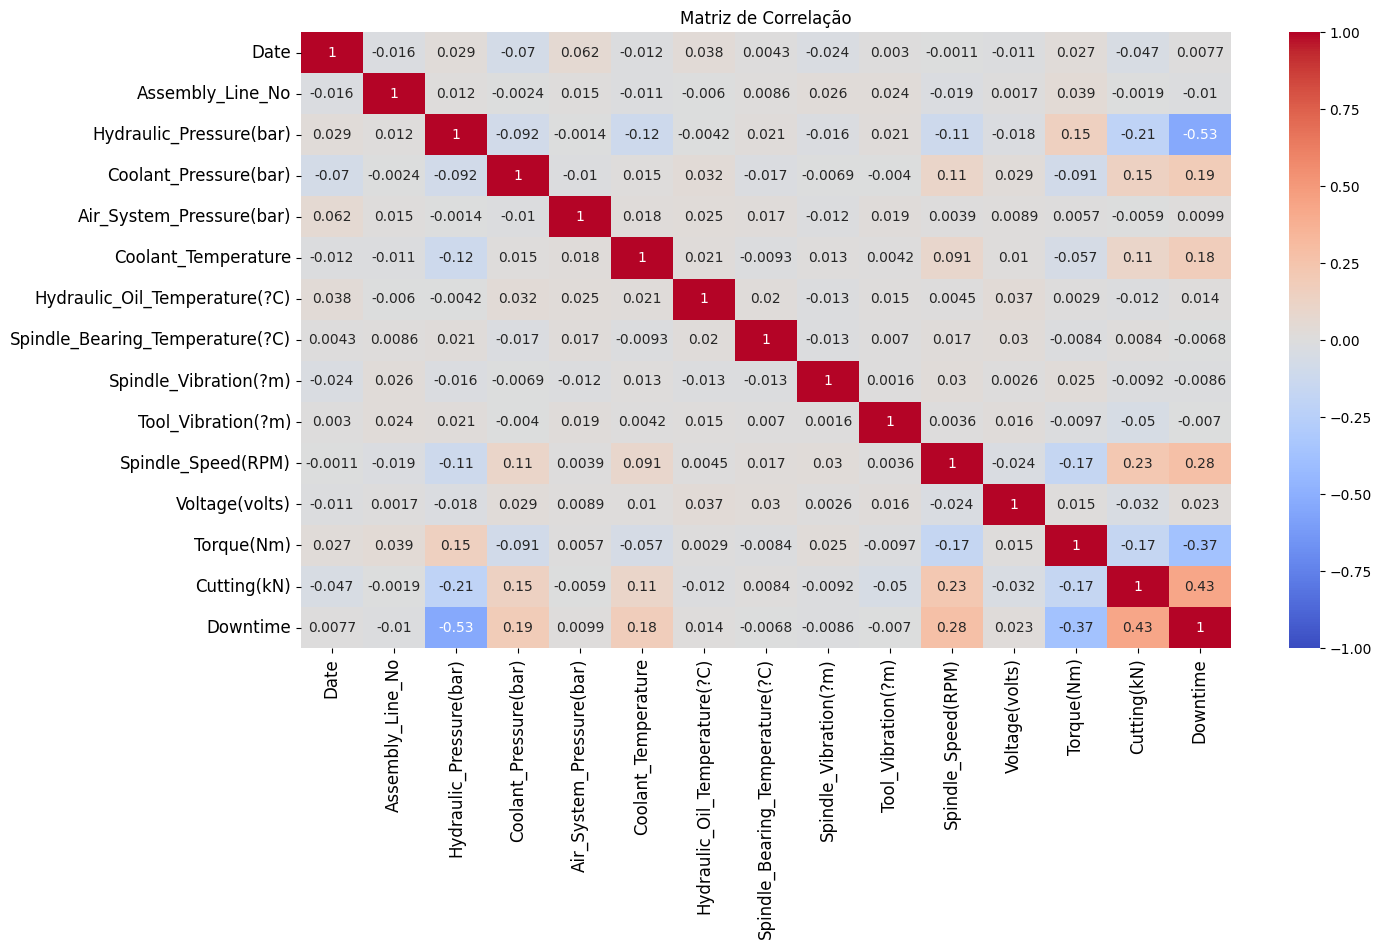

In [ ]:
plot_matriz_correlacao(matriz)

## Modelo de aprendizagem de máquina

In [ ]:
# Importação de bibliotecas necessárias
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [ ]:
#separando variaveis X e Y
X = df.drop('Downtime', axis=1)
y = df['Downtime']

In [ ]:
# Criando o objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajustando e transformando os dados
X_scaled = scaler.fit_transform(X)

# Dividindo o dataset em treinamento (70%) e teste (30%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42, stratify=y)

In [ ]:
# Criando o modelo de árvore de decisão
model = DecisionTreeClassifier(random_state=42,criterion="entropy")

# Treinando o modelo com os dados de treinamento
model.fit(X_train, y_train)

# Realizando previsões nos dados de teste
y_pred = model.predict(X_test)
accuracy_tree = accuracy_score(y_test, y_pred)

0.971


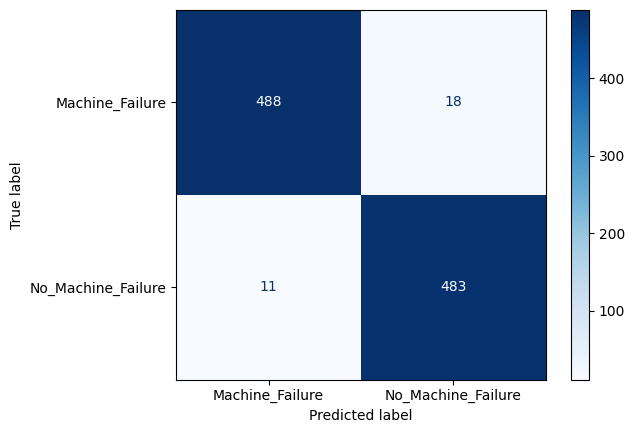

In [ ]:
# Calculando a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Exibindo a matriz de confusão como um gráfico
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['Downtime'].unique())
disp.plot(cmap="Blues")

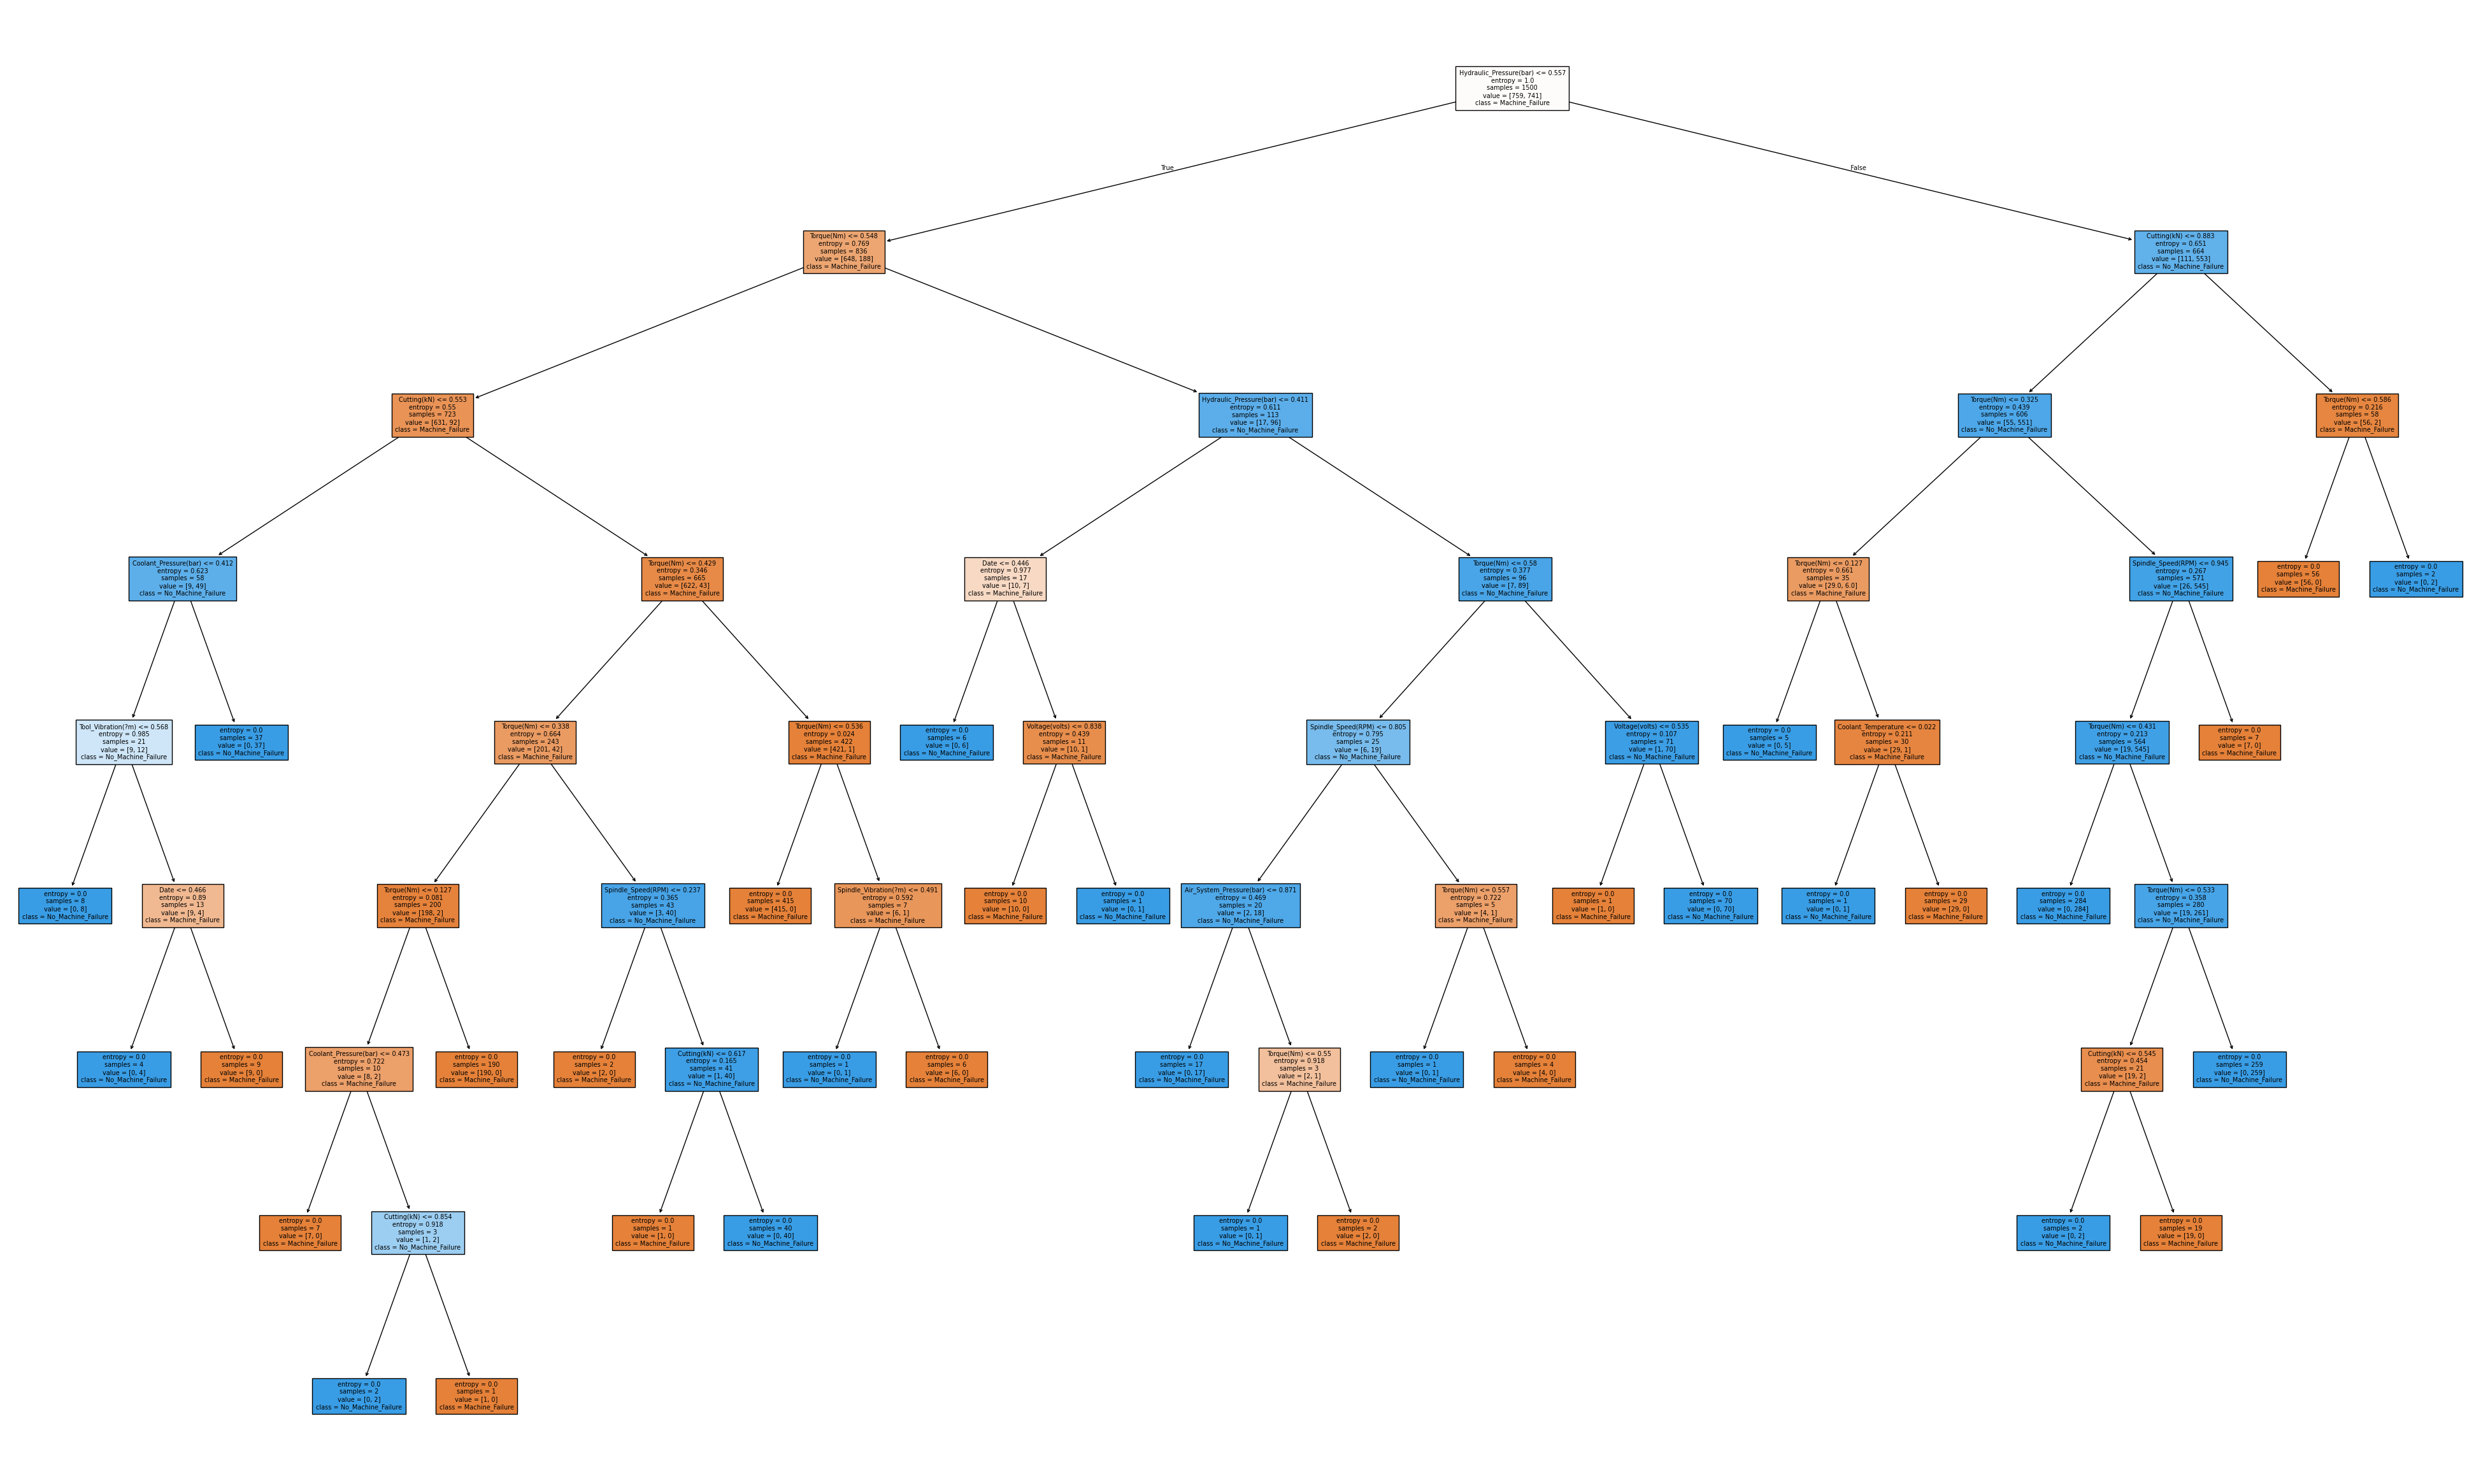

In [ ]:
plt.figure(figsize=(50, 30))
plot_tree(
    model,
    feature_names=X.columns,
    class_names=y.unique(),
    filled=True,
    #label='none',  # Remove os rótulos dos nós
    impurity=True,  # Remove a informação de impureza
#    proportion=False  # Remove proporções
    fontsize=7
)
plt.show()

In [ ]:
# Realizando GridSearch com GridSearchCV
hidden_layer_sizes = [
    (1024, 512, 256, 128),
    (2056, 1024, 512, 256, 128),
    (4096, 2048, 1024, 512, 256, 128),
]
print(hidden_layer_sizes)

param_grid = {
    'hidden_layer_sizes': hidden_layer_sizes,
    'activation': ['relu', 'tanh'],
}

grid_search = GridSearchCV(MLPClassifier(max_iter=10000, random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Melhor configuração:", grid_search.best_params_)

[(1024, 512, 256, 128), (2056, 1024, 512, 256, 128), (4096, 2048, 1024, 512, 256, 128)]
Melhor configuração: {'activation': 'tanh', 'hidden_layer_sizes': (2056, 1024, 512, 256, 128)} 0.9554285714285713


In [ ]:
# Criando o modelo de rede neural
model = MLPClassifier(hidden_layer_sizes=(2056, 1024, 512, 256, 128), activation='tanh', max_iter=1000, random_state=42)

# Treinando o modelo com os dados de treinamento
model.fit(X_train, y_train)

# Realizando previsões nos dados de teste
z_pred = model.predict(X_test)

#acurácia
accuracy_mlp = accuracy_score(y_test, z_pred)
print(f"Acurácia MLP: {accuracy_mlp:.3f}")
print(f"Acurácia Tree: {accuracy_tree:.3f}")

Acurácia MLP: 0.984
Acurácia Tree: 0.971


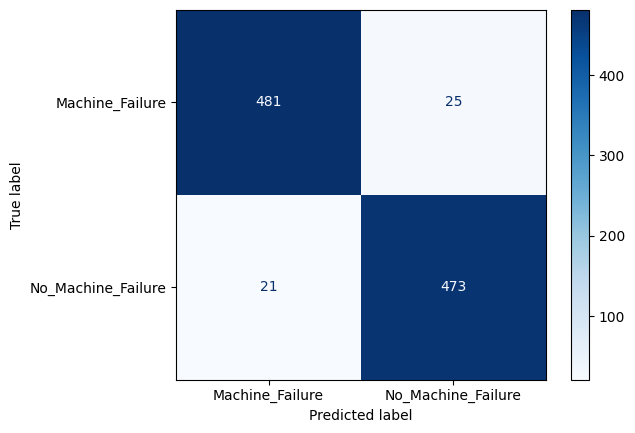

In [ ]:
# Calculando a matriz de confusão
cm = confusion_matrix(y_test, z_pred)

# Exibindo a matriz de confusão como um gráfico
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['Downtime'].unique())
disp.plot(cmap="Blues")

In [ ]:
# Modelo de regressão logistica
model = LogisticRegression(max_iter=2048)
model.fit(X_train, y_train)
y_pred_rl = model.predict(X_test)
accuracy_rl = accuracy_score(y_test, y_pred_rl)
print(f"Acurácia RL: {accuracy_rl:.3f}")

Acurácia RL: 0.846


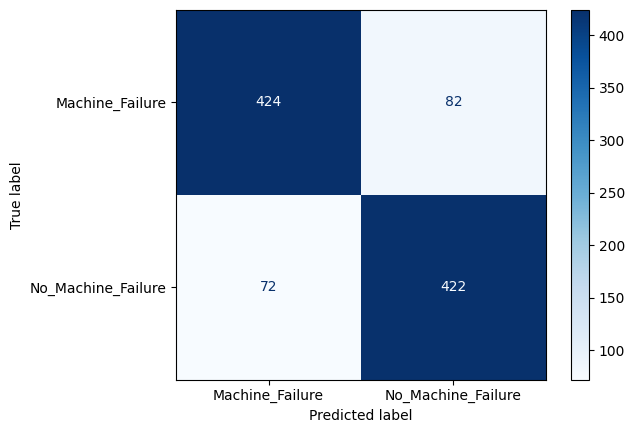

In [ ]:
# Calculando a matriz de confusão
cm = confusion_matrix(y_test, y_pred_rl)

# Exibindo a matriz de confusão como um gráfico
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['Downtime'].unique())
disp.plot(cmap="Blues")